# JAX 101 - 07 Parallel Evaluation
Link to the original JAX tutorial: https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html

## Part 0 - Data Owner Setup

In [1]:
# Import the necessary libraries
import syft as sy
sy.requires(">=0.8,<0.9")

import jax
import jax.numpy as jnp
import numpy as np

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /


✅ The installed version of syft==0.8.1b3 matches the requirement >=0.8 and the requirement <0.9


In [2]:
# Launch the domain
node = sy.orchestra.launch(name="test-domain-1", reset=True, dev_mode=True)
data_owner_client = node.login(email="info@openmined.org", password="changethis")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite



## Part 1 - Data Scientist

In [3]:
# Register a client to the domain
node = sy.orchestra.launch(name="test-domain-1")
data_scientist_client = node.client
data_scientist_client.register(name="Jane Doe", email="jane@caltech.edu", password="abc123", institution="Caltech", website="https://www.caltech.edu/")
data_scientist_client.login(email="jane@caltech.edu", password="abc123")

SQLite Store Path:
!open file:///var/folders/sz/hkfsnn612hq56r7cs5rd540r0000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite



<SyftClient - test-domain-1 <7bca415d13ed4ec881f0d0aede098dbb>: PythonConnection>

In [4]:
# Create a function for code execution
# ATTENTION: ALL LIBRARIES USED SHOULD BE DEFINED INSIDE THE FUNCTION CONTEXT!!!

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def basics():
    import jax
    import numpy as np
    import jax.numpy as jnp

    x = np.arange(5)
    w = np.array([2., 3., 4.])

    def convolve(x, w):
        output = []
        for i in range(1, len(x)-1):
            output.append(jnp.dot(x[i-1:i+2], w))
        return jnp.array(output)

    convolve(x, w)
    
    n_devices = jax.local_device_count() 
    xs = np.arange(5 * n_devices).reshape(-1, 5)
    ws = np.stack([w] * n_devices)

    xs
    ws
    jax.vmap(convolve)(xs, ws)
    jax.pmap(convolve)(xs, ws)
    jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))
    jax.pmap(convolve, in_axes=(0, None))(xs, w)
    
    def normalized_convolution(x, w):
        output = []
        for i in range(1, len(x)-1):
            output.append(jnp.dot(x[i-1:i+2], w))
        output = jnp.array(output)
        return output / jax.lax.psum(output, axis_name='p')

    jax.pmap(normalized_convolution, axis_name='p')(xs, ws)
    jax.vmap(normalized_convolution, axis_name='p')(xs, ws)

@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def complex_example():
    from typing import NamedTuple, Tuple
    import functools
    import jax
    import jax.numpy as jnp
    import numpy as np

    class Params(NamedTuple):
        weight: jnp.ndarray
        bias: jnp.ndarray


    def init(rng) -> Params:
        """Returns the initial model params."""
        weights_key, bias_key = jax.random.split(rng)
        weight = jax.random.normal(weights_key, ())
        bias = jax.random.normal(bias_key, ())
        return Params(weight, bias)


    def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
        """Computes the least squares error of the model's predictions on x against y."""
        pred = params.weight * xs + params.bias
        return jnp.mean((pred - ys) ** 2)

    LEARNING_RATE = 0.005

    # So far, the code is identical to the single-device case. Here's what's new:


    # Remember that the `axis_name` is just an arbitrary string label used
    # to later tell `jax.lax.pmean` which axis to reduce over. Here, we call it
    # 'num_devices', but could have used anything, so long as `pmean` used the same.
    @functools.partial(jax.pmap, axis_name='num_devices')
    def update(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> Tuple[Params, jnp.ndarray]:
        """Performs one SGD update step on params using the given data."""

        # Compute the gradients on the given minibatch (individually on each device).
        loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

        # Combine the gradient across all devices (by taking their mean).
        grads = jax.lax.pmean(grads, axis_name='num_devices')

        # Also combine the loss. Unnecessary for the update, but useful for logging.
        loss = jax.lax.pmean(loss, axis_name='num_devices')

        # Each device performs its own update, but since we start with the same params
        # and synchronise gradients, the params stay in sync.
        new_params = jax.tree_map(
            lambda param, g: param - g * LEARNING_RATE, params, grads)

        return new_params, loss
    
    # Generate true data from y = w*x + b + noise
    true_w, true_b = 2, -1
    xs = np.random.normal(size=(128, 1))
    noise = 0.5 * np.random.normal(size=(128, 1))
    ys = xs * true_w + true_b + noise

    # Initialise parameters and replicate across devices.
    params = init(jax.random.PRNGKey(123))
    n_devices = jax.local_device_count()
    replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
    
    type(replicated_params.weight)
    
    def split(arr):
        """Splits the first axis of `arr` evenly across the number of devices."""
        return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

    # Reshape xs and ys for the pmapped `update()`.
    x_split = split(xs)
    y_split = split(ys)

    type(x_split)
        
    def type_after_update(name, obj):
        print(f"after first `update()`, `{name}` is a", type(obj))

    # Actual training loop.
    for i in range(1000):

        # This is where the params and data gets communicated to devices:
        replicated_params, loss = update(replicated_params, x_split, y_split)

        # The returned `replicated_params` and `loss` are now both ShardedDeviceArrays,
        # indicating that they're on the devices.
        # `x_split`, of course, remains a NumPy array on the host.
        if i == 0:
            type_after_update('replicated_params.weight', replicated_params.weight)
            type_after_update('loss', loss)
            type_after_update('x_split', x_split)

        if i % 100 == 0:
            # Note that loss is actually an array of shape [num_devices], with identical
            # entries, because each device returns its copy of the loss.
            # So, we take the first element to print it.
            print(f"Step {i:3d}, loss: {loss[0]:.3f}")


    # Plot results.

    # Like the loss, the leaves of params have an extra leading dimension,
    # so we take the params from the first device.
    params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))
    import matplotlib.pyplot as plt
    plt.scatter(xs, ys)
    plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
    plt.legend()

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.pmap_lib.ShardedDeviceArray'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.pmap_lib.ShardedDeviceArray'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss: 7.536
Step 100, loss: 0.917
Step 200, loss: 0.349
Step 300, loss: 0.293
Step 400, loss: 0.286
Step 500, loss: 0.285
Step 600, loss: 0.285
Step 700, loss: 0.285
Step 800, loss: 0.285
Step 900, loss: 0.285


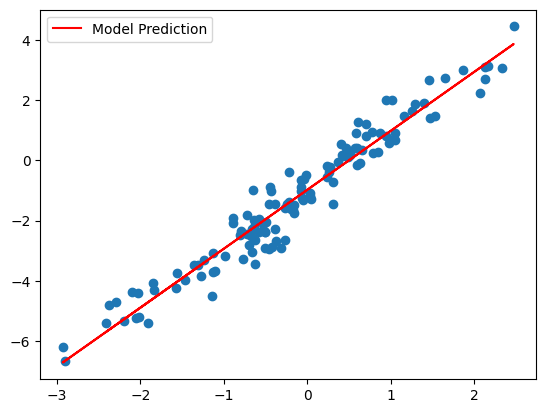

In [5]:
# Test our function locally 
basics()
complex_example()

In [6]:
# Submit the function for code execution
data_scientist_client.api.services.code.request_code_execution(basics)
data_scientist_client.api.services.code.request_code_execution(complex_example)

```python
class Request:
  id: str = a28fdad6e1474bd197398ad19194a2d7
  requesting_user_verify_key: str = 191bb81ac9620db8e141f1c2580a41b21d09937f6fdba29b8a1acb8cc42a85c5
  approving_user_verify_key: str = None
  request_time: str = 2023-05-29 06:33:00
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 7bca415d13ed4ec881f0d0aede098dbb
  request_hash: str = "ac0b3237970543c1d92880cf8d98c5986e06e72250b0c58af4be3750eb1e634a"
  changes: str = [syft.service.request.request.UserCodeStatusChange]

```

## Part 2 - Data Owner Reviewing and Approving Requests

In [7]:
data_owner_client = node.login(email="info@openmined.org", password="changethis")

In [8]:
# Get messages from domain
messages = data_owner_client.api.services.messages.get_all()
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,fefda4ee5b9a4815914e59652713a8e6,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:33:00,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,cc9ad8838367433bada58ccf52bf15a3,Approval Request,MessageStatus.UNDELIVERED,2023-05-29 06:33:00,<<class 'syft.service.request.request.Request'...


complex_example
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def complex_example():
    from typing import NamedTuple, Tuple
    import functools
    import jax
    import jax.numpy as jnp
    import numpy as np

    class Params(NamedTuple):
        weight: jnp.ndarray
        bias: jnp.ndarray


    def init(rng) -> Params:
        """Returns the initial model params."""
        weights_key, bias_key = jax.random.split(rng)
        weight = jax.random.normal(weights_key, ())
        bias = jax.random.normal(bias_key, ())
        return Params(weight, bias)


    def loss_fn(params: Params, xs: jnp.ndarray, ys: jnp.ndarray) -> jnp.ndarray:
        """Computes the least squares error of the model's predictions on x against y."""
        pred = params.weight * xs + params.bias
        return jnp.mean((pred - ys) ** 2)

    LEARNING_RATE = 0.005

    # So far, the code is identical to the single-device case. Here's what'

exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


basics
@sy.syft_function(input_policy=sy.ExactMatch(),
                  output_policy=sy.SingleExecutionExactOutput())
def basics():
    import jax
    import numpy as np
    import jax.numpy as jnp

    x = np.arange(5)
    w = np.array([2., 3., 4.])

    def convolve(x, w):
        output = []
        for i in range(1, len(x)-1):
            output.append(jnp.dot(x[i-1:i+2], w))
        return jnp.array(output)

    convolve(x, w)
    
    n_devices = jax.local_device_count() 
    xs = np.arange(5 * n_devices).reshape(-1, 5)
    ws = np.stack([w] * n_devices)

    xs
    ws
    jax.vmap(convolve)(xs, ws)
    jax.pmap(convolve)(xs, ws)
    jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))
    jax.pmap(convolve, in_axes=(0, None))(xs, w)
    
    def normalized_convolution(x, w):
        output = []
        for i in range(1, len(x)-1):
            output.append(jnp.dot(x[i-1:i+2], w))
        output = jnp.array(output)
        return output / jax.lax.psum(output, axis_name='p')

    

exec_result=syft.service.code.user_code.UserCodeExecutionResult
action_object=Pointer:
syft.service.code.user_code.UserCodeExecutionResult


message='Request 82e0d3ba4c824b379f753d9e84b4d463 changes applied'


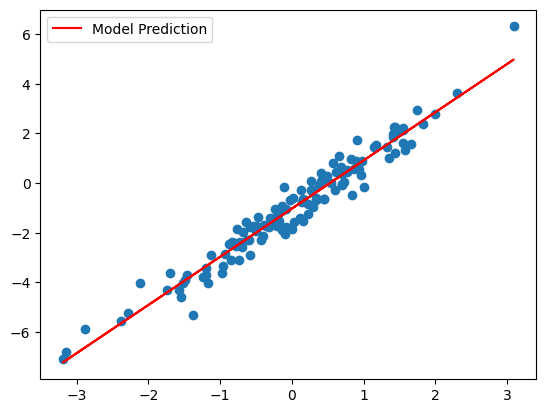

In [9]:
from helpers import review_request, run_submitted_function, accept_request

for message in messages:
    review_request(message)
    real_result = run_submitted_function(message)
    accept_request(message, real_result)

## Part 3 - Downloading the Results

### Tutorial complete 👏

In [10]:
result = data_scientist_client.api.services.code.basics()
assert not isinstance(result, sy.SyftError)

result = data_scientist_client.api.services.code.complex_example()
assert not isinstance(result, sy.SyftError)

In [11]:
if node.node_type.value == "python":
    node.land()